In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from models.soft_actor_critic import SoftActorCritic
from rl_models.her import HindsightExperienceReplay
from rl_models.replay_buffer import ReplayBuffer
from rl_models.utils import plot_learning_curve

In [3]:
# !pip3 install -U gymnasium

In [4]:
max_episode_steps = 50
env = gym.make('FetchReach-v2', max_episode_steps=max_episode_steps)

env.action_space, env.observation_space

(Box(-1.0, 1.0, (4,), float32),
 Dict('achieved_goal': Box(-inf, inf, (3,), float64), 'desired_goal': Box(-inf, inf, (3,), float64), 'observation': Box(-inf, inf, (10,), float64)))

In [5]:
class RandomAgent:
    def get_action(self, state):
        return env.action_space.sample()

In [6]:
env.reset()

({'observation': array([ 1.34185486e+00,  7.49100508e-01,  5.34707205e-01,  2.00232294e-04,
          6.92377335e-05, -3.25336729e-06, -2.19655130e-09,  5.16581247e-06,
          4.76882452e-06, -2.31810359e-06]),
  'achieved_goal': array([1.34185486, 0.74910051, 0.5347072 ]),
  'desired_goal': array([1.42393209, 0.71275352, 0.47331647])},
 {})

In [7]:
env.step(env.action_space.sample())

({'observation': array([ 1.34799004e+00,  7.60212161e-01,  5.34257300e-01,  0.00000000e+00,
          0.00000000e+00,  5.38563973e-03,  9.43808989e-03, -3.78706667e-04,
          8.51047818e-05,  2.25219902e-04]),
  'achieved_goal': array([1.34799004, 0.76021216, 0.5342573 ]),
  'desired_goal': array([1.42393209, 0.71275352, 0.47331647])},
 -1.0,
 False,
 False,
 {'is_success': 0.0})

In [8]:
random_agent = RandomAgent()

In [9]:
def play_game(agent):
    state = env.reset()
    done = False
    score = 0.0
    for i in range(max_episode_steps):
        action = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)
        
        score += reward
        state = next_state
        if done:
            break
    return score

100%|██████████| 10/10 [00:00<00:00, 12.71it/s]


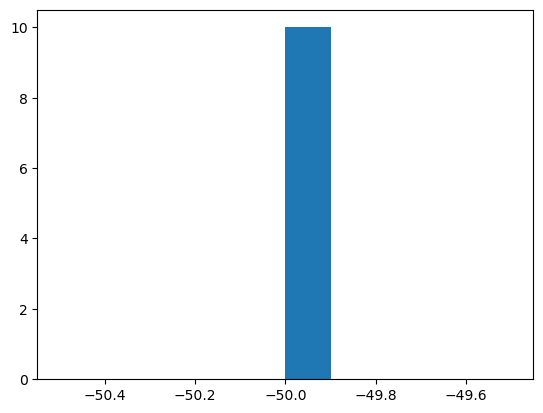

-50.0

In [10]:
tests = []
for i in tqdm(range(10)):
    result = play_game(random_agent)
    tests.append(result)
    
plt.hist(tests) 
plt.show()
np.mean(tests)

In [11]:
state_dim = env.observation_space['observation'].shape[0]
goal_dim = env.observation_space['desired_goal'].shape[0]
actions_dim = env.action_space.shape[0]
state_dim, actions_dim

(10, 4)

In [12]:
epochs = 100
epoch_iters = 50
success_history = []
batch_size = 128

In [13]:
agent = SoftActorCritic(state_dim + goal_dim, actions_dim, hidden_size=256, lr=1e-3, scale_action=5)
replay_buffer = ReplayBuffer(100000)
her = HindsightExperienceReplay(env, agent, replay_buffer, 
                                batch_size=batch_size, max_steps=max_episode_steps)

In [14]:
her.play_and_learn()

(-48.75, 0.0)

Epoch 64 success rate = 0.0


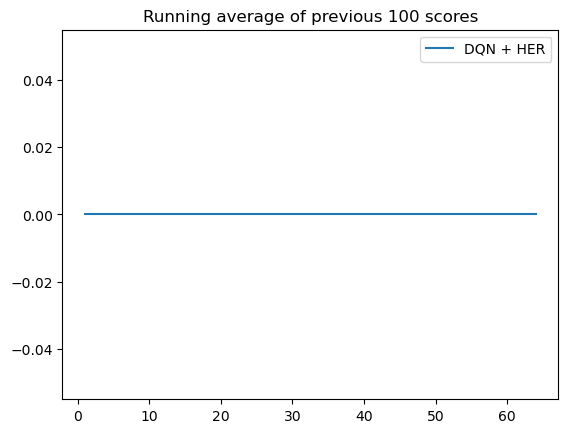

  2%|▏         | 1/50 [00:04<03:57,  4.84s/it]


KeyboardInterrupt: 

In [15]:
for epoch in range(epochs):
    score_history = []
    for iter in tqdm(range(epoch_iters)):
        score, success = her.play_and_learn(num_episodes=16)
        score_history.append(float(success))

    # if agent.epsilon > 0:
    #     agent.epsilon -= 0.01

    success_rate = np.mean(score_history)
    success_history.append(success_rate)
    plot_learning_curve(len(success_history), success_history, name="DQN + HER") 

    print(f"Epoch {epoch + 1} success rate = {success_rate}")
    plt.show()